In [ ]:
import tensorflow as tf
import os
import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate
from keras.utils import plot_model
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Input,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
import keras.callbacks as kcallbacks
from keras.models import load_model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Concatenate, GlobalAveragePooling2D, Flatten, Dropout, Dense, AveragePooling2D, Attention
from tensorflow.keras.regularizers import l2

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
data_dir='/content/drive/MyDrive/Project/dataset'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,

    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1216 files belonging to 7 classes.


The dataset containing 7 different classes. The classes are shown below.

In [ ]:
class_names=dataset.class_names
class_names


['1. No DR signs',
 '2. Mild (or early) NPDR',
 '3. Moderate NPDR',
 '4. Severe NPDR',
 '5. Very Severe NPDR',
 '6. PDR',
 '7. Advanced PDR']

The dimension of the image is given below with 32 batches and image height and width is 256 and the image is in RGB.

In [ ]:
for image_batch,label_batch in dataset.take(1):
  print(image_batch.shape)

(32, 256, 256, 3)


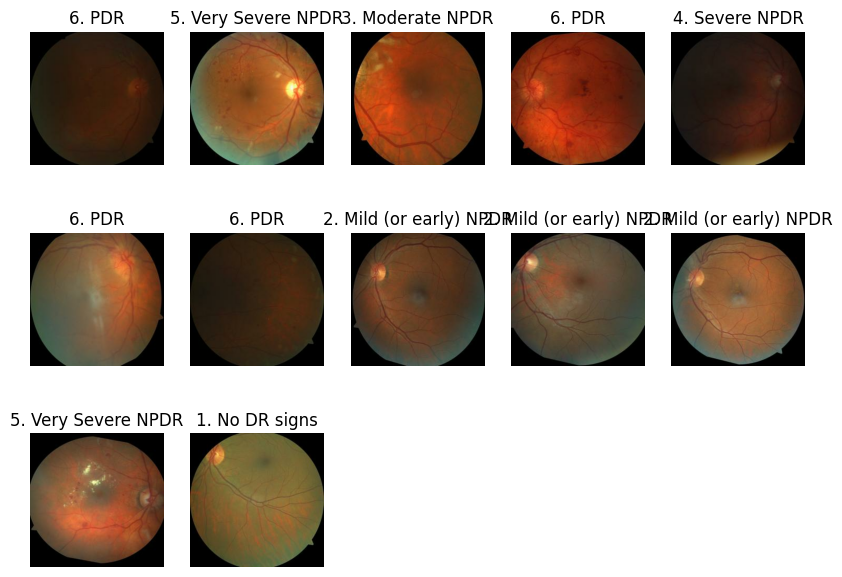

In [ ]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(4,5,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')


Splitted the dataset into three partitions: a training set, validation set and a test set. These partitions are defined by the specified split ratios. The dataset is shuffled to ensure randomness in the data. The shuffle_size parameter controls the number of elements to sample when shuffling. Seed=12 is used to initialize the random number generator before shuffling the dataset. This ensures that if someone else runs the same code with the same seed value we will get the same shuffled order of elements. Then we created the training set. After that the validation set is created by skipping the dataset that is already allocated for training purposes. Finally  the test set is also created skipping both the dataset that has already been taken by the training and validation set. Thus we get all the three training, validation and test sets.

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=20000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

We working with different architecture and finding the best one. First work with ResNet50.

**RESNET50**




In [ ]:
# Define the Residual Block
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x


    # First convolutional layer
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Second convolutional layer
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Shortcut connection
    if stride != 1 or shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)

    return x

# Define the ResNet50 model
def create_resnet50_model(input_shape, n_classes):
    inputs = layers.Input(shape=input_shape)

    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)

    x = residual_block(x, filters=128, stride=2)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)
    x = residual_block(x, filters=128)

    x = residual_block(x, filters=256, stride=2)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)
    x = residual_block(x, filters=256)

    x = residual_block(x, filters=512, stride=2)
    x = residual_block(x, filters=512)
    x = residual_block(x, filters=512)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    return model

# Set the input shape and number of classes
input_shape = (256, 256, 3)  # Image dimensions
n_classes = 7  # Number of classes in ImageNet

# Create the ResNet50 model
resnet50_model = create_resnet50_model(input_shape, n_classes)

custom_learning_rate = 0.001

# Create the SGD optimizer with the custom learning rate
custom_optimizer = tf.keras.optimizers.SGD(learning_rate=custom_learning_rate)



# Compile the model
resnet50_model.compile(optimizer=custom_optimizer,
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics=['accuracy'])

In [ ]:
history =resnet50_model.fit(
    train_ds,
    epochs=30,
    batch_size=32,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
26/26 [==============================] - 19s 294ms/step - loss: 1.9807 - accuracy: 0.2933 - val_loss: 5.9010 - val_accuracy: 0.1437
Epoch 2/30
26/26 [==============================] - 7s 256ms/step - loss: 1.5548 - accuracy: 0.4351 - val_loss: 4.6856 - val_accuracy: 0.2188
Epoch 3/30
26/26 [==============================] - 7s 257ms/step - loss: 1.4091 - accuracy: 0.5024 - val_loss: 2.6568 - val_accuracy: 0.2438
Epoch 4/30
26/26 [==============================] - 6s 248ms/step - loss: 1.2946 - accuracy: 0.5697 - val_loss: 2.2527 - val_accuracy: 0.3063
Epoch 5/30
26/26 [==============================] - 7s 258ms/step - loss: 1.2190 - accuracy: 0.6022 - val_loss: 2.1617 - val_accuracy: 0.2500
Epoch 6/30
26/26 [==============================] - 6s 241ms/step - loss: 1.1299 - accuracy: 0.6406 - val_loss: 1.6486 - val_accuracy: 0.3625
Epoch 7/30
26/26 [==============================] - 6s 240ms/step - loss: 1.0497 - accuracy: 0.6743 - val_loss: 1.7200 - val_accuracy: 0.3562
Epoch

In [ ]:
acc=resnet50_model.evaluate(train_ds)
acc

26/26 [==============================] - 2s 74ms/step - loss: 0.3279 - accuracy: 0.8942


[0.32792332768440247, 0.8942307829856873]

In [ ]:
tst=resnet50_model.evaluate(test_ds)
tst

7/7 [==============================] - 4s 77ms/step - loss: 0.3472 - accuracy: 0.8973


[0.34716740250587463, 0.8973214030265808]

In [ ]:
val_acc=resnet50_model.evaluate(val_ds)
val_acc

5/5 [==============================] - 0s 79ms/step - loss: 0.4208 - accuracy: 0.8813


[0.4208222031593323, 0.8812500238418579]

For evaluating the accuracy and loss of the training and validation sets using a graph.

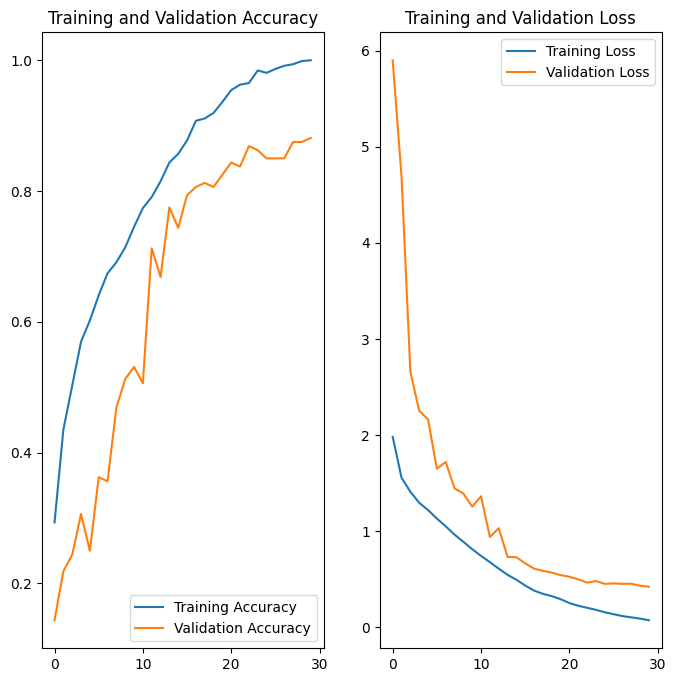

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(30), loss, label='Training Loss')
plt.plot(range(30), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Next, building the architecture of InceptionV3 by making some changes in the architecture.

**INCEPTIONV3**

For inception image is resized into **299x299**

In [ ]:
img_input=Input(shape=(299,299,3))
classes=7
channel_axis=3
IMAGE_SIZE=299


In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/new_datasize",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 1216 files belonging to 7 classes.


Train, validation and Test data split.

In [ ]:
def dataset_partition(ds,train_split=.8,val_split=.2,test_split=0,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size=len(ds)

    if shuffle:
      ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


train_ds,val_ds,test_ds=dataset_partition(dataset)


trian_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Model Building

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Flatten, Dense, Dropout, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization

# Define the number of classes
num_classes = 7

# Define the input shape
input_shape = (299, 299, 3)

# Create an Inception-A block
def inception_a(x):
    # 1x1 Convolution
    conv1x1 = Conv2D(64, (1, 1), padding='same', activation='relu')(x)

    # 3x3 Convolution
    conv3x3=Conv2D(64,(1,1), padding='same',activation='relu')(x)
    conv3x3 = Conv2D(96, (1, 1), padding='same', activation='relu')(conv3x3)
    conv3x3 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3x3)

    # 5x5 Convolution
    conv5x5 = Conv2D(16, (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(32, (5, 5), padding='same', activation='relu')(conv5x5)

    # Maxpooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(32, (1, 1), padding='same', activation='relu')(pool)

    # Concatenate the output of all branches
    output = concatenate([conv1x1, conv3x3, conv5x5, pool], axis=-1)
    return output

# Create an Inception-B block
def inception_b(x):
    # 1x1 Convolution
    conv1x1 = Conv2D(192, (1, 1), padding='same', activation='relu')(x)

    # 7x7 Convolution
    conv7x7 = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    conv7x7 = Conv2D(128, (1, 7), padding='same', activation='relu')(conv7x7)
    conv7x7 = Conv2D(192, (7, 1), padding='same', activation='relu')(conv7x7)

    # Maxpooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(192, (1, 1), padding='same', activation='relu')(pool)

    # Concatenate the output of all branches
    output = concatenate([conv1x1, conv7x7, pool], axis=-1)
    return output

# Create an Inception-C block
def inception_c(x):
    # 1x1 Convolution
    conv1x1 = Conv2D(320, (1, 1), padding='same', activation='relu')(x)

    # 3x3 Convolution
    conv3x3_1 = Conv2D(384, (1, 1), padding='same', activation='relu')(x)
    conv3x3_2a = Conv2D(384, (1, 3), padding='same', activation='relu')(conv3x3_1)
    conv3x3_2b = Conv2D(384, (3, 1), padding='same', activation='relu')(conv3x3_1)
    conv3x3 = concatenate([conv3x3_2a, conv3x3_2b], axis=-1)

    # Maxpooling
    pool = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool = Conv2D(192, (1, 1), padding='same', activation='relu')(pool)

    # Concatenate the output of all branches
    output = concatenate([conv1x1, conv3x3, pool], axis=-1)
    return output




def create_inception_model():
    input_layer = Input(shape=input_shape)

    # Initial Convolution
    x = Conv2D(32, (3, 3), strides=(2, 2), activation='relu')(input_layer)
    x=Conv2D(32,(3,3),padding='valid')(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x=Conv2D(80,(1,1),padding='valid')(x)
    x=Conv2D(192,(3,3),padding='valid')(x)

    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)


    # Inception blocks
    x = inception_a(x)
    x = inception_a(x)
    x = inception_a(x)




    # Inception blocks
    x = inception_b(x)
    x = inception_b(x)
    x = inception_b(x)
    x = inception_b(x)

 #   x=reduction_b(x)

    x=inception_c(x)
    x=inception_c(x)
    x=inception_c(x)

    # Average Pooling
    x = AveragePooling2D(pool_size=(8, 8))(x)

    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)

    output_layer = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='inceptionv')
    return model

# Create the InceptionV3 model
inception= create_inception_model()

# Compile the model
opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
inception.compile(optimizer=opt, loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])



In [ ]:
history=inception.fit(
    train_ds,
    epochs=50,
    batch_size=32,
    verbose=1,
    validation_data=val_ds,

                              )

Epoch 1/50
30/30 [==============================] - 50s 783ms/step - loss: 2.5897 - accuracy: 0.1521 - val_loss: 1.9105 - val_accuracy: 0.1696
Epoch 2/50
30/30 [==============================] - 26s 801ms/step - loss: 1.9342 - accuracy: 0.1833 - val_loss: 1.8859 - val_accuracy: 0.2098
Epoch 3/50
30/30 [==============================] - 26s 784ms/step - loss: 1.9022 - accuracy: 0.2135 - val_loss: 1.9072 - val_accuracy: 0.2857
Epoch 4/50
30/30 [==============================] - 26s 780ms/step - loss: 1.8369 - accuracy: 0.2740 - val_loss: 1.7193 - val_accuracy: 0.3884
Epoch 5/50
30/30 [==============================] - 25s 755ms/step - loss: 1.6687 - accuracy: 0.3698 - val_loss: 1.4869 - val_accuracy: 0.5179
Epoch 6/50
30/30 [==============================] - 25s 762ms/step - loss: 1.5434 - accuracy: 0.4375 - val_loss: 1.4706 - val_accuracy: 0.4866
Epoch 7/50
30/30 [==============================] - 25s 747ms/step - loss: 1.4642 - accuracy: 0.4531 - val_loss: 1.3294 - val_accuracy: 0.5491

In [ ]:
val_acc=inception.evaluate(val_ds)
val_acc

7/7 [==============================] - 2s 227ms/step - loss: 0.1906 - accuracy: 0.9375


[0.19061031937599182, 0.9375]

In [ ]:
test_acc=inception.evaluate(test_ds)
test_acc

1/1 [==============================] - 0s 292ms/step - loss: 0.1864 - accuracy: 0.9375


[0.18639704585075378, 0.9375]

In [ ]:
acc_1=inception.evaluate(train_ds)
acc_1

30/30 [==============================] - 10s 227ms/step - loss: 0.1872 - accuracy: 0.9385


[0.18715868890285492, 0.9385416507720947]

In [ ]:
inception.save('/content/drive/MyDrive/model')

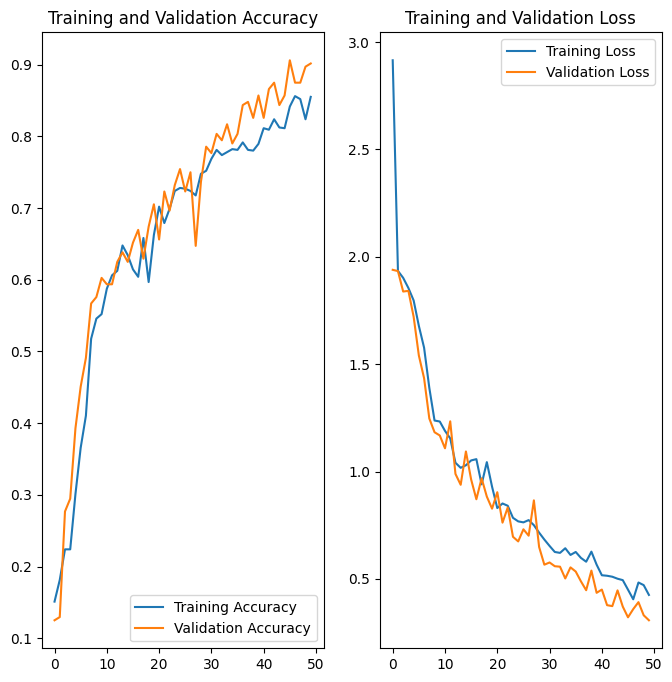

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/model')

 **VGG19**

In [ ]:
data_dir='/content/drive/MyDrive/Project/new_dataset'
IMAGE_SIZE = 224


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1216 files belonging to 7 classes.


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape=(224,224,3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def vgg_model(input_shape=(224, 224, 3)):
    # Define the input layer
    input_layer = Input(shape=input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = BatchNormalization()(x)

    # Flatten and fully connected layers
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(7, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name="vgg")
    return model

# Create the VGG model
vgg = vgg_model()

# Compile the model
opt = tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
vgg.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer=opt, metrics=['accuracy'])

# Print model summary
vgg.summary()


Model: "vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_32 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 conv2d_33 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 batch_normalization_10 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 conv2d_34 (Conv2D)          (None, 112, 112, 128)     73856   

In [ ]:
history=vgg.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
30/30 [==============================] - 16s 548ms/step - loss: 3.4894 - accuracy: 0.1909 - val_loss: 174.3409 - val_accuracy: 0.1979
Epoch 2/50
30/30 [==============================] - 16s 542ms/step - loss: 1.9867 - accuracy: 0.2426 - val_loss: 5.5542 - val_accuracy: 0.1458
Epoch 3/50
30/30 [==============================] - 16s 544ms/step - loss: 1.8487 - accuracy: 0.2384 - val_loss: 3.4911 - val_accuracy: 0.1875
Epoch 4/50
30/30 [==============================] - 16s 539ms/step - loss: 1.7726 - accuracy: 0.3122 - val_loss: 2.0398 - val_accuracy: 0.2812
Epoch 5/50
30/30 [==============================] - 16s 539ms/step - loss: 1.6810 - accuracy: 0.3724 - val_loss: 2.4423 - val_accuracy: 0.2604
Epoch 6/50
30/30 [==============================] - 16s 540ms/step - loss: 1.5664 - accuracy: 0.4209 - val_loss: 1.6067 - val_accuracy: 0.3854
Epoch 7/50
30/30 [==============================] - 16s 539ms/step - loss: 1.5918 - accuracy: 0.4114 - val_loss: 1.7013 - val_accuracy: 0.26

In [ ]:
A=vgg.evaluate(test_ds)
A

5/5 [==============================] - 1s 159ms/step - loss: 0.8901 - accuracy: 0.7250


[0.8901075124740601, 0.7250000238418579]

In [ ]:
B=vgg.evaluate(train_ds)
B

30/30 [==============================] - 5s 159ms/step - loss: 0.8620 - accuracy: 0.7342


[0.8620321154594421, 0.7341772317886353]

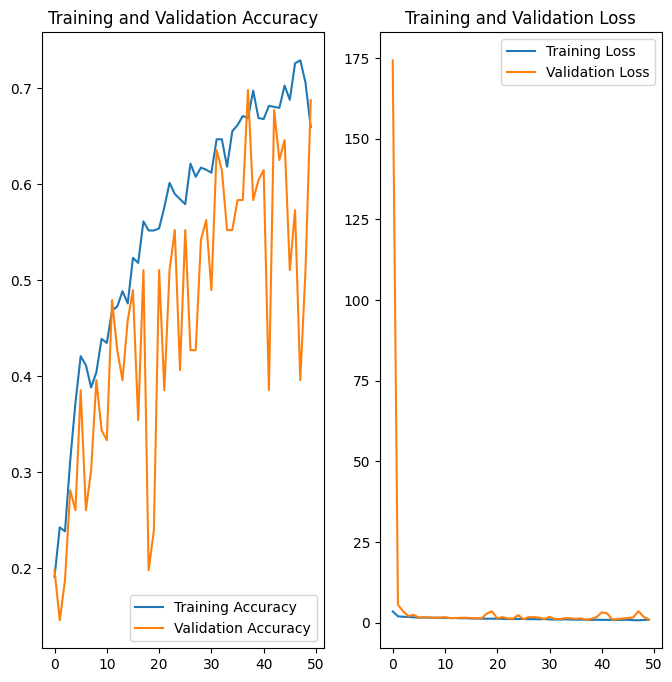

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**DenseNet**


In [ ]:
def dataset_partition(ds,train_split=.55,val_split=.15,test_split=.3,shuffle=True,shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size=len(ds)

    if shuffle:
      ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds


train_ds,val_ds,test_ds=dataset_partition(dataset)


trian_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:

def bottleneck_block_with_attention(x, growth_rate):
    # First convolution (1x1)
    x1 = BatchNormalization()(x)
    x1 = ReLU()(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x1)

    # Second convolution (3x3)
    x2 = BatchNormalization()(x1)
    x2 = ReLU()(x2)
    x2 = Conv2D(growth_rate, (3, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x2)

    # Self-attention
    x2 = Attention()([x2, x2])


    return x2

def dense_block_with_attention(x, blocks, growth_rate):
    for _ in range(blocks):
        xn = bottleneck_block_with_attention(x, growth_rate)
        x = Concatenate()([x, xn])

    return x

def transition_block(x, compression):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(int(x.shape[-1] * compression), (1, 1), padding='same')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

def build_densenet_with_attention(input_shape, num_blocks, growth_rate, num_classes):
    input_layer = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=(2, 2), padding='same')(x)

    for blocks in num_blocks:
        x = dense_block_with_attention(x, blocks, growth_rate)
        if len(num_blocks) > 1:
            x = transition_block(x, 0.5)  # Compression factor can be adjusted

    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(200, activation="relu")(x)
    x = Dropout(0.2)(x)
    output_layer = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model


input_shape = (256, 256, 3)
num_blocks = [6, 10, 12, 10]  # Number of dense blocks in each dense block group
growth_rate = 32
num_classes = 7

densenet_model_with_attention = build_densenet_with_attention(input_shape, num_blocks, growth_rate, num_classes)
densenet_model_with_attention.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_81 (Conv2D)             (None, 128, 128, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_81 (BatchN  (None, 128, 128, 64  256        ['conv2d_81[0][0]']              
 ormalization)                  )                                                           

In [ ]:
#combile model
optimizer = Adam(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
metrics = ['accuracy']
densenet_model_with_attention.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
history = densenet_model_with_attention.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
    )

Epoch 1/50
20/20 [==============================] - 10s 417ms/step - loss: 1.8509 - accuracy: 0.7547 - val_loss: 7.9680 - val_accuracy: 0.1875
Epoch 2/50
20/20 [==============================] - 10s 417ms/step - loss: 2.2713 - accuracy: 0.6016 - val_loss: 7.6107 - val_accuracy: 0.2188
Epoch 3/50
20/20 [==============================] - 10s 414ms/step - loss: 2.1421 - accuracy: 0.6453 - val_loss: 5.8897 - val_accuracy: 0.1437
Epoch 4/50
20/20 [==============================] - 11s 413ms/step - loss: 2.1089 - accuracy: 0.6313 - val_loss: 5.6780 - val_accuracy: 0.1562
Epoch 5/50
20/20 [==============================] - 10s 413ms/step - loss: 2.0495 - accuracy: 0.6828 - val_loss: 3.9326 - val_accuracy: 0.1750
Epoch 6/50
20/20 [==============================] - 10s 415ms/step - loss: 1.9689 - accuracy: 0.6969 - val_loss: 3.0331 - val_accuracy: 0.2375
Epoch 7/50
20/20 [==============================] - 10s 416ms/step - loss: 1.9013 - accuracy: 0.7359 - val_loss: 2.6978 - val_accuracy: 0.4375

In [ ]:
densenet_model_with_attention.evaluate(train_ds)

20/20 [==============================] - 5s 115ms/step - loss: 1.5566 - accuracy: 0.7937


[1.5565664768218994, 0.793749988079071]

In [ ]:
densenet_model_with_attention.evaluate(val_ds)

5/5 [==============================] - 1s 124ms/step - loss: 1.6286 - accuracy: 0.7625


[1.6285778284072876, 0.762499988079071]

In [ ]:
densenet_model_with_attention.evaluate(test_ds)

13/13 [==============================] - 4s 114ms/step - loss: 1.5944 - accuracy: 0.7788


[1.5944132804870605, 0.7788461446762085]

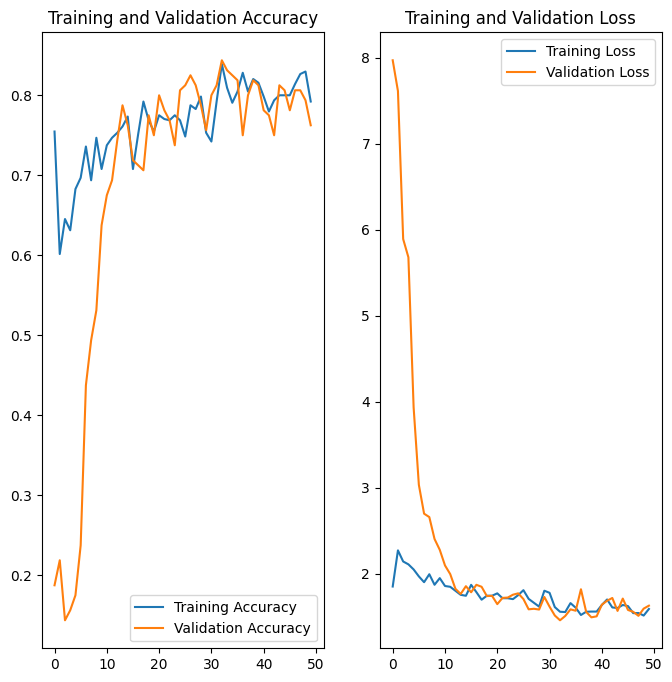

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc, label='Training Accuracy')
plt.plot(range(50), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss, label='Training Loss')
plt.plot(range(50), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()